In [715]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import math

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [716]:
df = pd.read_csv('JUIndoorLoc-Training-data.csv')
df_test = pd.read_csv('JUIndoorLoc-Test-data.csv')

In [717]:
df.shape

(23904, 177)

In [718]:
df_test.shape

(1460, 177)

In [719]:
split_cols = df['Cid'].str.lstrip('L').str.split('-', expand=True)

# Step 2: Assign new columns
df['floor'] = split_cols[0].astype(int)  # floor as integer
df['X'] = split_cols[1].astype(int)      # X coordinate
df['Y'] = split_cols[2].astype(int)      # Y coordinate

In [720]:
split_cols = df_test['Cid'].str.lstrip('L').str.split('-', expand=True)

# Step 2: Assign new columns
df_test['floor'] = split_cols[0].astype(int)  # floor as integer
df_test['X'] = split_cols[1].astype(int)      # X coordinate
df_test['Y'] = split_cols[2].astype(int)      # Y coordinate

In [721]:
def train_test_split_by_xy(df, test_frac=0.2, random_state=None):
    """
    Split df into train/test so that each (X,Y) group contributes test_frac of its rows to test.
    
    Parameters
    ----------
    df : pd.DataFrame
      Must contain columns 'X' and 'Y'.
    test_frac : float
      Fraction of each (X,Y)-group to put into the test set.
    random_state : int or None
      Seed for reproducibility.
    
    Returns
    -------
    train_df, test_df : pd.DataFrame
    """
    rng = np.random.RandomState(random_state)
    train_parts = []
    test_parts = []
    
    # Group by the coordinate pairs
    for _, group in df.groupby(['X','Y'], sort=False):
        # sample 20% of this group for test
        test = group.sample(frac=test_frac, random_state=rng)
        # the rest go to train
        train = group.drop(test.index)
        
        test_parts.append(test)
        train_parts.append(train)
    
    # concat & shuffle
    test_df  = pd.concat(test_parts,  axis=0).sample(frac=1, random_state=rng).reset_index(drop=True)
    train_df = pd.concat(train_parts, axis=0).sample(frac=1, random_state=rng).reset_index(drop=True)
    
    return train_df, test_df

In [722]:
filtered_df = df[df['floor'] == 4]
print("\nFloor distribution in training data:")
print(filtered_df['Rs'].value_counts())


Floor distribution in training data:
Rs
1    10844
0     7172
Name: count, dtype: int64


In [723]:
filtered_df = df[df['floor'] == 4]
print("\nFloor distribution in training data:")
print(filtered_df['Hpr'].value_counts())


Floor distribution in training data:
Hpr
1    10943
0     7073
Name: count, dtype: int64


In [724]:
ffiltered_df = filtered_df[filtered_df['Rs'] == 1]
print("\nFloor distribution in training data:")
print(ffiltered_df['Rs'].value_counts())


Floor distribution in training data:
Rs
1    10844
Name: count, dtype: int64


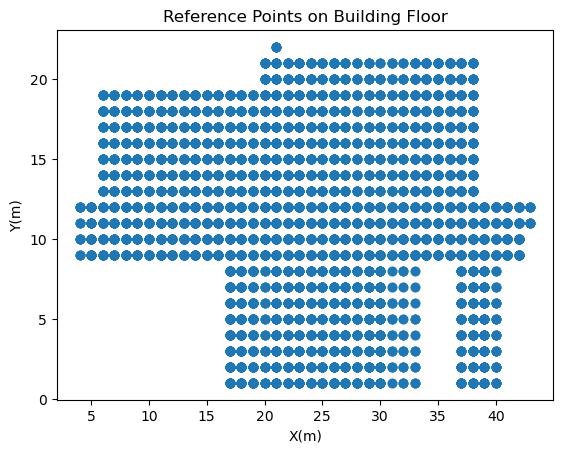

In [725]:
fig, ax = plt.subplots()
ax.scatter(ffiltered_df['X'], ffiltered_df['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [726]:
print(ffiltered_df['Rs'].value_counts())

Rs
1    10844
Name: count, dtype: int64


In [727]:
ffiltered_df = ffiltered_df.drop(columns=['Cid', 'Rs', 'Hpr', 'Did', 'Ts', 'floor'])    

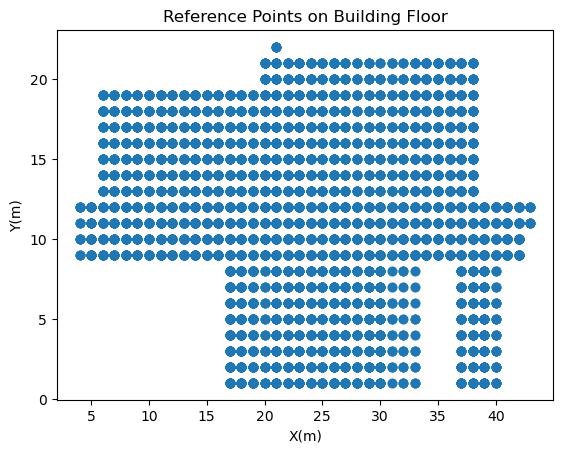

In [728]:
fig, ax = plt.subplots()
ax.scatter(ffiltered_df['X'], ffiltered_df['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [729]:
fffiltered_df = ffiltered_df[(ffiltered_df['X'] >= 17) & (ffiltered_df['X'] <= 31) & (ffiltered_df['Y'] <= 16)]

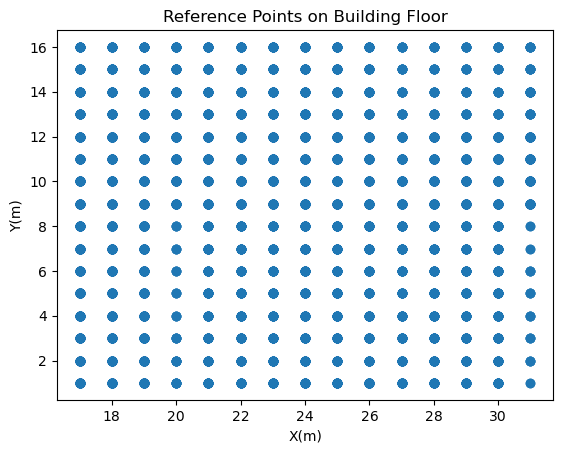

In [730]:
fig, ax = plt.subplots()
ax.scatter(fffiltered_df['X'], fffiltered_df['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [731]:
fffiltered_df, df_test = train_test_split_by_xy(fffiltered_df, test_frac=0.2, random_state=42)

In [732]:
df_test.shape

(865, 174)

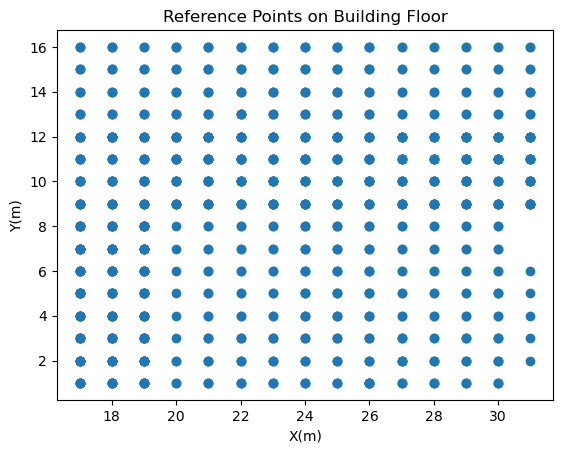

In [733]:
fig, ax = plt.subplots()
ax.scatter(df_test['X'], df_test['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [734]:
fffiltered_df.shape

(3503, 174)

In [735]:
def subsample_every_n(df, N, origin=(None,None), tol=1e-8):
    """
    Split df into two parts:
      • df_kept: rows where (X−x0) and (Y−y0) are multiples of N  
      • df_rest: all the other rows
    
    Parameters
    ----------
    df : DataFrame with columns 'X','Y'
    N  : float           the grid spacing you want (e.g. 5.0)
    origin : (x0,y0)     the “zero” of your grid; if None, uses (min X, min Y)
    tol : float          tolerance for floating-point modulo
    
    Returns
    -------
    df_kept, df_rest : DataFrames
    """
    df2 = df.copy()
    
    # 1) determine grid origin
    x0 = origin[0] if origin[0] is not None else df2['X'].min()
    y0 = origin[1] if origin[1] is not None else df2['Y'].min()
    
    # 2) compute offsets
    dx = df2['X'] - x0
    dy = df2['Y'] - y0
    
    # 3) boolean mask for “on-grid” points
    on_grid = (
        np.isclose(dx.mod(N), 0.0, atol=tol) &
        np.isclose(dy.mod(N), 0.0, atol=tol)
    )
    
    # 4) split
    df_kept = df2.loc[on_grid].reset_index(drop=True)
    df_rest = df2.loc[~on_grid].reset_index(drop=True)
    
    return df_kept, df_rest

In [851]:
filtered, _ = subsample_every_n(fffiltered_df, N=1.0)

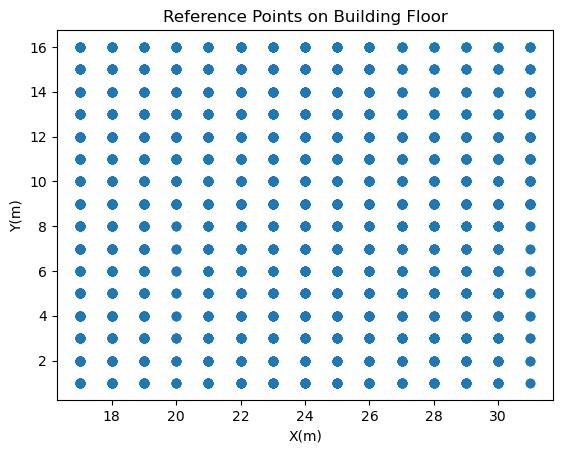

In [852]:
fig, ax = plt.subplots()
ax.scatter(filtered['X'], filtered['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [853]:
filtered.shape

(3503, 174)

In [854]:
fffiltered_df.shape

(3503, 174)

In [740]:
group_counts = (
    filtered
    .groupby(['X','Y'])
    .size()
    .reset_index(name='count')
)
group_counts.describe()

,X,Y,count
count,240.000000,240.000000,240.000000
mean,24.000000,8.500000,14.595833
std,4.329523,4.619406,6.507092
min,17.000000,1.000000,2.000000
25%,20.000000,4.750000,10.000000
50%,24.000000,8.500000,13.000000
75%,28.000000,12.250000,21.000000
max,31.000000,16.000000,34.000000


In [741]:
group_counts = (
    fffiltered_df
    .groupby(['X','Y'])
    .size()
    .reset_index(name='count')
)
group_counts.describe()

,X,Y,count
count,240.000000,240.000000,240.000000
mean,24.000000,8.500000,14.595833
std,4.329523,4.619406,6.507092
min,17.000000,1.000000,2.000000
25%,20.000000,4.750000,10.000000
50%,24.000000,8.500000,13.000000
75%,28.000000,12.250000,21.000000
max,31.000000,16.000000,34.000000


In [742]:
'''fffiltered_df = ffiltered_df[(ffiltered_df['X'] >= 33) & (ffiltered_df['Y'] >= 13)]'''

"fffiltered_df = ffiltered_df[(ffiltered_df['X'] >= 33) & (ffiltered_df['Y'] >= 13)]"

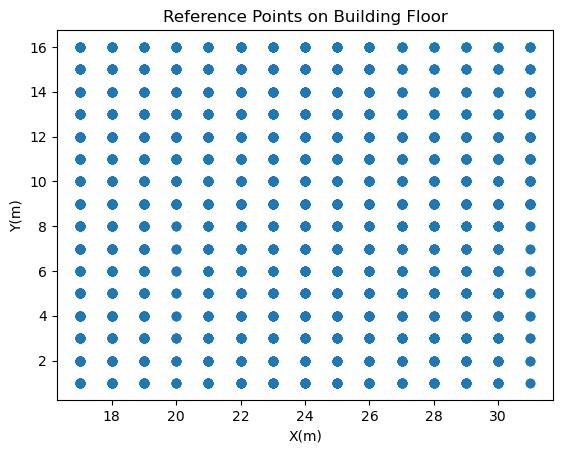

In [743]:
fig, ax = plt.subplots()
ax.scatter(filtered['X'], filtered['Y'])
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_title('Reference Points on Building Floor')
plt.show()

In [744]:
filtered.head()

,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,AP010,...,AP165,AP166,AP167,AP168,AP169,AP170,AP171,AP172,X,Y
0,-110,-110,-38,-62,-84,-37,-37,-69,-110,-82,...,-110,-110,-110,-110,-110,-110,-110,-110,17,13
1,-110,-110,-56,-77,-110,-56,-55,-38,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,19,6
2,-54,-54,-53,-55,-110,-53,-52,-84,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,20,11
3,-67,-67,-68,-44,-110,-67,-68,-82,-110,-86,...,-110,-110,-110,-110,-110,-110,-110,-110,29,11
4,-69,-69,-53,-68,-86,-55,-53,-82,-110,-87,...,-110,-110,-110,-110,-110,-110,-110,-110,27,16


In [745]:
filtered.shape

(3503, 174)

# Data prepocess

In [746]:
df = filtered

In [747]:
# Calculate percentage of "null" (value == 100) per column
null_percent = (df == -110).sum() / len(df) * 100

print(null_percent)

AP001     15.358264
AP002     15.044248
AP003      1.227519
AP004     14.330574
AP005     62.061090
            ...    
AP170    100.000000
AP171    100.000000
AP172    100.000000
X          0.000000
Y          0.000000
Length: 174, dtype: float64


In [748]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Columns: 174 entries, AP001 to Y
dtypes: int64(174)
memory usage: 4.7 MB


In [749]:
df_clean = df.replace(-110, np.nan)

In [750]:
df_clean.isna()

,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,AP010,...,AP165,AP166,AP167,AP168,AP169,AP170,AP171,AP172,X,Y
0,True,True,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,False,False
1,True,True,False,False,True,False,False,False,True,True,...,True,True,True,True,True,True,True,True,False,False
2,False,False,False,False,True,False,False,False,True,True,...,True,True,True,True,True,True,True,True,False,False
3,False,False,False,False,True,False,False,False,True,False,...,True,True,True,True,True,True,True,True,False,False
4,False,False,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,True,False,False,False,True,False,False,False,True,True,...,True,True,True,True,True,True,True,True,False,False
3499,False,False,False,False,True,False,False,False,True,False,...,True,True,True,True,True,True,True,True,False,False
3500,False,False,False,False,True,False,False,False,True,True,...,True,True,True,True,True,True,True,True,False,False
3501,False,False,False,False,False,False,False,False,True,False,...,True,True,True,True,True,True,True,True,False,False


In [751]:
threshold = 0.9  # 30%

null_percent = df_clean.isna().mean()  # fraction of nulls per column

cols_to_drop = null_percent[null_percent >= threshold].index

df_dropped = df_clean.drop(columns=cols_to_drop)

print("Dropped columns:", list(cols_to_drop))
print(df_dropped)

Dropped columns: ['AP009', 'AP012', 'AP013', 'AP015', 'AP022', 'AP026', 'AP028', 'AP031', 'AP032', 'AP033', 'AP034', 'AP035', 'AP036', 'AP037', 'AP038', 'AP039', 'AP040', 'AP041', 'AP042', 'AP043', 'AP044', 'AP045', 'AP048', 'AP050', 'AP051', 'AP054', 'AP056', 'AP057', 'AP058', 'AP059', 'AP061', 'AP062', 'AP063', 'AP064', 'AP065', 'AP066', 'AP067', 'AP068', 'AP069', 'AP070', 'AP071', 'AP072', 'AP073', 'AP074', 'AP075', 'AP076', 'AP077', 'AP078', 'AP079', 'AP080', 'AP081', 'AP082', 'AP083', 'AP084', 'AP085', 'AP086', 'AP087', 'AP088', 'AP089', 'AP090', 'AP091', 'AP092', 'AP093', 'AP094', 'AP095', 'AP096', 'AP097', 'AP098', 'AP099', 'AP100', 'AP101', 'AP102', 'AP103', 'AP104', 'AP105', 'AP106', 'AP107', 'AP108', 'AP109', 'AP110', 'AP111', 'AP112', 'AP113', 'AP114', 'AP115', 'AP116', 'AP117', 'AP118', 'AP119', 'AP120', 'AP121', 'AP122', 'AP124', 'AP125', 'AP126', 'AP127', 'AP128', 'AP129', 'AP130', 'AP131', 'AP132', 'AP133', 'AP134', 'AP135', 'AP136', 'AP137', 'AP138', 'AP139', 'AP140', '

In [752]:
null_percent = df_dropped.isna().mean() * 100
print(null_percent)

AP001    15.358264
AP002    15.044248
AP003     1.227519
AP004    14.330574
AP005    62.061090
AP006     0.770768
AP007     0.628033
AP008    16.157579
AP010    62.146731
AP011    64.972880
AP014    40.422495
AP016    87.467885
AP017    32.229518
AP018    88.952327
AP019    32.143877
AP020    88.952327
AP021    15.929204
AP023    32.429346
AP024    33.828147
AP025    76.876963
AP027    80.302598
AP029    17.242364
AP030    34.227805
AP046    69.369112
AP047    70.767913
AP049    78.218670
AP052    85.326863
AP053    51.041964
AP055    80.588067
AP060    73.080217
AP123    81.244647
X         0.000000
Y         0.000000
dtype: float64


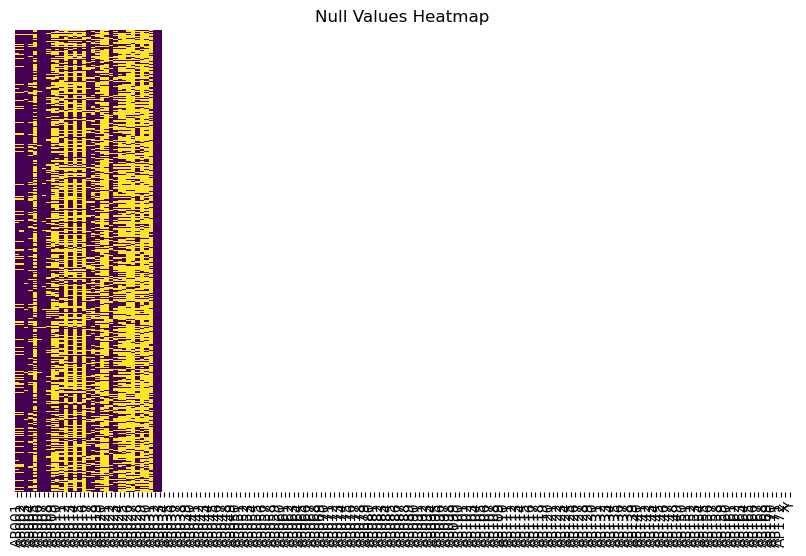

In [753]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a boolean DataFrame for null values
null_map = df_dropped.isna()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(null_map, cmap='viridis', cbar=False, yticklabels=False, xticklabels=df.columns)
plt.xticks(rotation=90)
plt.title("Null Values Heatmap")
plt.show()

In [754]:
df_dropped.head()

,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP010,AP011,...,AP046,AP047,AP049,AP052,AP053,AP055,AP060,AP123,X,Y
0,NaN,NaN,-38.0,-62.0,-84.0,-37.0,-37.0,-69.0,-82.0,-81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,13
1,NaN,NaN,-56.0,-77.0,NaN,-56.0,-55.0,-38.0,NaN,NaN,...,-84.0,NaN,-76.0,NaN,-74.0,NaN,-79.0,NaN,19,6
2,-54.0,-54.0,-53.0,-55.0,NaN,-53.0,-52.0,-84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-96.0,NaN,NaN,NaN,20,11
3,-67.0,-67.0,-68.0,-44.0,NaN,-67.0,-68.0,-82.0,-86.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,11
4,-69.0,-69.0,-53.0,-68.0,-86.0,-55.0,-53.0,-82.0,-87.0,-88.0,...,NaN,NaN,NaN,NaN,NaN,-81.0,NaN,NaN,27,16


In [755]:
df_dropped.shape

(3503, 33)

In [756]:
df.shape

(3503, 174)

In [757]:
# Suppose df has columns: [X, Y, RSS_1, RSS_2, ..., RSS_k]
# We'll treat X, Y as conditions and the RSS columns as numeric data to be diffused.
cond_cols = ["X", "Y"]
rss_cols = [c for c in df_dropped.columns if c not in cond_cols]

X_cond = df[cond_cols].values            # shape: (n_samples, 2)
y_rss = df[rss_cols].values              # shape: (n_samples, k)


In [758]:
X_cond.shape

(3503, 2)

In [759]:
y_rss.shape

(3503, 31)

In [760]:
# Scale RSS columns
scaler = StandardScaler()

# Train / Validation Split
X_train_cond, X_val_cond, y_train_rss, y_val_rss = train_test_split(
    X_cond, y_rss, test_size=0.2, random_state=42
)
y_train_rss_scaled = scaler.fit_transform(y_train_rss)
y_val_rss_scaled = scaler.transform(y_val_rss)

# Convert to torch Tensors
X_train_cond_t = torch.tensor(X_train_cond, dtype=torch.float32)
X_val_cond_t   = torch.tensor(X_val_cond,   dtype=torch.float32)
y_train_rss_t  = torch.tensor(y_train_rss_scaled,  dtype=torch.float32)
y_val_rss_t    = torch.tensor(y_val_rss_scaled,    dtype=torch.float32)

In [761]:
X_train_cond.shape

(2802, 2)

In [762]:
# ---------------------------
# 2) Define the Cosine Noise Schedule
# ---------------------------
def get_beta(t, T):
    """
    Cosine schedule:
    beta_t = (1 - cos(pi * t / T)) / 2
    t in [0, T-1], T is the total number of diffusion steps.
    """
    return (1.0 - math.cos(math.pi * t / T)) / 2.0


In [763]:
# ---------------------------
# 2) Sinusoidal Time Embedding
# ---------------------------
def get_timestep_embedding(timesteps: torch.Tensor, dim: int) -> torch.Tensor:
    half = dim // 2
    omega = torch.exp(-math.log(10000) * torch.arange(0, half, device=timesteps.device) / (half - 1))
    args = timesteps.float().unsqueeze(1) * omega.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2:
        emb = F.pad(emb, (0, 1))
    return emb


In [764]:
class TabularUNet(nn.Module):
    def __init__(self, input_dim: int, cond_dim: int, time_emb_dim: int, hidden_dims: list[int] = [512, 256, 128]):
        super().__init__()
        # Heads for time and condition
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, hidden_dims[0])
        )
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, hidden_dims[0]),
            nn.SiLU()
        )

        # Encoder blocks
        dims = [input_dim + hidden_dims[0]*2] + hidden_dims[:-1]
        self.encoder_blocks = nn.ModuleList(
            nn.Sequential(nn.Linear(in_d, out_d), nn.SiLU())
            for in_d, out_d in zip(dims, hidden_dims)
        )

        # Decoder blocks
        rev = hidden_dims[::-1]
        self.decoder_blocks = nn.ModuleList(
            nn.Sequential(nn.Linear(in_d*2, out_d), nn.SiLU())
            for in_d, out_d in zip(rev[:-1], rev[1:])
        )

        # Final layer
        self.output_layer = nn.Linear(hidden_dims[0], input_dim)

    def forward(self, x: torch.Tensor, cond: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        # x: (batch, input_dim)
        # cond: (batch, cond_dim)
        # t_emb: (batch, time_emb_dim)
        t_h = self.time_mlp(t_emb)
        c_h = self.cond_mlp(cond)

        h = torch.cat([x, c_h, t_h], dim=1)
        skips = []
        # Encode
        for enc in self.encoder_blocks:
            h = enc(h)
            skips.append(h)
        # Decode
        for dec in self.decoder_blocks:
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = dec(h)
        return self.output_layer(h)

In [765]:
# ---------------------------
# 4) Diffusion Model with Tabular U-Net
# ---------------------------
class TableDiffusionModel(nn.Module):
    def __init__(self, rss_dim: int, cond_dim: int, time_emb_dim: int, hidden_dims: list[int] = [512,256,128]):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        # Core U-Net
        self.unet = TabularUNet(
            input_dim=rss_dim,
            cond_dim=cond_dim,
            time_emb_dim=time_emb_dim,
            hidden_dims=hidden_dims
        )

    def forward(self, rss_noised: torch.Tensor, cond: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Compute time embedding
        t_emb = get_timestep_embedding(t, self.time_emb_dim)
        # Predict noise
        return self.unet(rss_noised, cond, t_emb)

In [766]:
def evaluate_table_diffusion(model, X_val, y_val, diffusion_steps=50):
    """
    Evaluate the performance of the TableDiffusionModel.
    
    Args:
        model: Instance of the trained TableDiffusionModel.
        X_val: Validation data of shape (N, cond_dim) with conditions (e.g., X, Y).
        y_val: Validation target data of shape (N, rss_dim) with clean RSS data.
        diffusion_steps: Number of diffusion steps.
    
    Returns:
        val_loss: Mean squared error loss between the predicted noise and the true noise for all steps.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    mse_loss_fn = nn.MSELoss()
    
    with torch.no_grad():
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        
        # Start by generating the noised data over all diffusion steps
        aggregated_loss = 0.0
        
        for t in range(diffusion_steps):
            beta_t = get_beta(t, diffusion_steps)
            noise = torch.randn_like(y_val) * np.sqrt(beta_t)
            noised_data = y_val + noise
            
            # Create a tensor for the current time step (t) for each sample in the batch
            t_tensor = torch.full((y_val.shape[0],), t, device=device, dtype=torch.long)
            
            # Predict the noise using the model with time step conditioning
            predicted_noise = model(noised_data, X_val, t_tensor)
            
            # Compute MSE loss between predicted noise and true noise
            loss = mse_loss_fn(predicted_noise, noise)
            aggregated_loss += loss
        
        # Compute the average loss over all diffusion steps
        val_loss = aggregated_loss / diffusion_steps
    
    return val_loss.item()

# Example usage:
#val_loss = evaluate_table_diffusion(table_diffusion_model, X_val_cond_t, y_val_rss_t, diffusion_steps=500)
#rint(f"Validation (noise-prediction) MSE: {val_loss:.4f}")


In [767]:
# ---------------------------
# 5) Training Function
# ---------------------------

def train_table_diffusion(
    model: TableDiffusionModel,
    X_cond: torch.Tensor,
    y_rss: torch.Tensor,
    diffusion_steps: int = 100,
    batch_size: int = 128,
    n_epochs: int = 20,
    lr: float = 1e-3
) -> TableDiffusionModel:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataset = torch.utils.data.TensorDataset(X_cond, y_rss)
    loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    model.train()

    for epoch in range(1, n_epochs+1):
        total = 0.0
        for cond_batch, rss_batch in loader:
            cond_batch, rss_batch = cond_batch.to(device), rss_batch.to(device)
            loss_accum = 0.0
            for t in range(diffusion_steps):
                beta = get_beta(t, diffusion_steps)
                noise = torch.randn_like(rss_batch) * np.sqrt(beta)
                noised = rss_batch + noise
                t_vec = torch.full((rss_batch.size(0),), t, dtype=torch.long, device=device)
                pred = model(noised, cond_batch, t_vec)
                loss_accum += mse(pred, noise)
            loss = loss_accum / diffusion_steps
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total += loss.item()
        print(f"Epoch {epoch}/{n_epochs} — Loss: {total/len(loader):.4f}")
    return model


In [768]:
# Instantiate the model
rss_dim = y_train_rss_t.shape[1]  # number of RSS columns
table_diffusion_model = TableDiffusionModel(rss_dim=rss_dim, cond_dim=2, time_emb_dim=128)

# Train
#hidden_dim': 128, 'time_emb_dim': 128, 'learning_rate': 0.0006314620153594548, 'batch_size': 32, 'diffusion_steps': 5
table_diffusion_model = train_table_diffusion(
    model=table_diffusion_model,
    X_cond=X_train_cond_t,
    y_rss=y_train_rss_t,
    diffusion_steps=100,   # you can tune
    batch_size=32,
    n_epochs=200,
    lr=0.0006314620153594548
)


Epoch 1/200 — Loss: 0.4783
Epoch 2/200 — Loss: 0.3752
Epoch 3/200 — Loss: 0.2603
Epoch 4/200 — Loss: 0.2240
Epoch 5/200 — Loss: 0.2139
Epoch 6/200 — Loss: 0.2078
Epoch 7/200 — Loss: 0.2020
Epoch 8/200 — Loss: 0.1948
Epoch 9/200 — Loss: 0.1881
Epoch 10/200 — Loss: 0.1824
Epoch 11/200 — Loss: 0.1751
Epoch 12/200 — Loss: 0.1690
Epoch 13/200 — Loss: 0.1657
Epoch 14/200 — Loss: 0.1598
Epoch 15/200 — Loss: 0.1579
Epoch 16/200 — Loss: 0.1529
Epoch 17/200 — Loss: 0.1503
Epoch 18/200 — Loss: 0.1466
Epoch 19/200 — Loss: 0.1442
Epoch 20/200 — Loss: 0.1425
Epoch 21/200 — Loss: 0.1398
Epoch 22/200 — Loss: 0.1385
Epoch 23/200 — Loss: 0.1376
Epoch 24/200 — Loss: 0.1333
Epoch 25/200 — Loss: 0.1325
Epoch 26/200 — Loss: 0.1294
Epoch 27/200 — Loss: 0.1287
Epoch 28/200 — Loss: 0.1257
Epoch 29/200 — Loss: 0.1241
Epoch 30/200 — Loss: 0.1224
Epoch 31/200 — Loss: 0.1206
Epoch 32/200 — Loss: 0.1188
Epoch 33/200 — Loss: 0.1170
Epoch 34/200 — Loss: 0.1157
Epoch 35/200 — Loss: 0.1135
Epoch 36/200 — Loss: 0.1115
E

In [769]:
# ---------------------------
# 6) Sampling Function
# ---------------------------

def sample_table_diffusion(
    model: TableDiffusionModel,
    X_cond: torch.Tensor,
    diffusion_steps: int = 100
) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    X_cond = X_cond.to(device)
    n, _ = X_cond.shape
    rss_dim = model.unet.output_layer.out_features
    samples = torch.randn(n, rss_dim, device=device)

    with torch.no_grad():
        for t in reversed(range(diffusion_steps)):
            beta = get_beta(t, diffusion_steps)
            t_vec = torch.full((n,), t, dtype=torch.long, device=device)
            pred = model(samples, X_cond, t_vec)
            samples = samples - pred * np.sqrt(beta)
    return samples.cpu().numpy()


In [770]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [771]:
X_cond[0]

array([17, 13])

In [772]:
y_rss[0:2]

array([[-110, -110,  -38,  -62,  -84,  -37,  -37,  -69,  -82,  -81,  -83,
        -110,  -83, -110, -110, -110,  -76, -110,  -85,  -77,  -81,  -66,
        -110, -110, -110, -110, -110, -110, -110, -110, -110],
       [-110, -110,  -56,  -77, -110,  -56,  -55,  -38, -110, -110, -110,
        -110, -110, -110, -110, -110,  -64,  -76, -110, -110, -110,  -60,
         -77,  -84, -110,  -76, -110,  -74, -110,  -79, -110]])

In [773]:
X_cond_for_generation = torch.tensor([[34, 13], [34, 13]], dtype=torch.float32)
gen_rss_scaled = sample_table_diffusion(table_diffusion_model, X_cond_for_generation, diffusion_steps=100)

# Invert the scaling if desired:
gen_rss = scaler.inverse_transform(gen_rss_scaled)
print("Generated Synthetic RSS:\n", gen_rss)

Generated Synthetic RSS:
 [[ -70.324486  -67.43408   -63.28835   -43.132767  -88.61007   -64.09078
   -62.116653 -109.22261   -95.50981   -84.95588   -91.92962  -108.17822
  -109.527435 -109.82677   -95.62079  -109.62472   -89.94748  -109.03324
  -113.91569  -112.41131  -109.16141   -81.238304 -105.748276 -113.19166
  -115.50034  -115.168724 -111.29247  -109.23492  -109.53858  -114.54201
  -112.073845]
 [ -70.32449   -67.43409   -63.28835   -43.132763  -88.61007   -64.09078
   -62.116653 -109.22261   -95.50981   -84.95588   -91.92962  -108.17822
  -109.527435 -109.82677   -95.62079  -109.62472   -89.94748  -109.03324
  -113.91569  -112.41131  -109.16141   -81.238304 -105.748276 -113.19166
  -115.50034  -115.168724 -111.29247  -109.23492  -109.53858  -114.54201
  -112.073845]]


# KNN model eval

In [774]:
'''df_test = df_test.drop(columns=['Cid', 'Rs', 'Hpr', 'Did', 'Ts', 'floor'])    '''

"df_test = df_test.drop(columns=['Cid', 'Rs', 'Hpr', 'Did', 'Ts', 'floor'])    "

In [775]:
df_test = df_test.drop(columns=cols_to_drop)

In [776]:
df_test.head()

,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP010,AP011,...,AP046,AP047,AP049,AP052,AP053,AP055,AP060,AP123,X,Y
0,-110,-110,-67,-110,-110,-65,-75,-38,-110,-110,...,-86,-86,-110,-110,-80,-110,-84,-110,17,6
1,-67,-68,-62,-59,-110,-62,-61,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,27,12
2,-66,-66,-46,-52,-110,-50,-49,-84,-84,-83,...,-110,-110,-110,-110,-110,-110,-110,-87,29,10
3,-70,-73,-48,-73,-110,-53,-52,-65,-110,-110,...,-110,-110,-110,-110,-89,-110,-110,-110,29,3
4,-54,-49,-53,-58,-110,-53,-52,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,21,12


In [777]:
rss_cols

['AP001',
 'AP002',
 'AP003',
 'AP004',
 'AP005',
 'AP006',
 'AP007',
 'AP008',
 'AP010',
 'AP011',
 'AP014',
 'AP016',
 'AP017',
 'AP018',
 'AP019',
 'AP020',
 'AP021',
 'AP023',
 'AP024',
 'AP025',
 'AP027',
 'AP029',
 'AP030',
 'AP046',
 'AP047',
 'AP049',
 'AP052',
 'AP053',
 'AP055',
 'AP060',
 'AP123']

In [778]:
'''import optuna

# Define a function to compute the Euclidean distance error.
def compute_localization_errors(true_locations, predicted_locations):
    errors = np.sqrt(np.sum((true_locations - predicted_locations)**2, axis=1))
    return errors

def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256, 512])
    time_emb_dim = trial.suggest_categorical('time_emb_dim', [64, 128, 256])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    diffusion_steps = trial.suggest_categorical('diffusion_steps', [5, 10, 20, 30, 40, 50])
    
    # Instantiate and train the model
    model = TableDiffusionModel(rss_dim=y_train_rss_t.shape[1], cond_dim=X_train_cond_t.shape[1], 
                                hidden_dim=hidden_dim, time_emb_dim=time_emb_dim)
    
    model = train_table_diffusion(
        model=model,
        X_cond=X_train_cond_t,
        y_rss=y_train_rss_t,
        diffusion_steps=diffusion_steps,
        batch_size=batch_size,
        n_epochs=250,
        lr=learning_rate
    )
    
    # Evaluate model
    # For indoor localization, we use RSS values (columns 2:13) as features and (X, Y) as targets.
    # We create a separate train-test split.
    X_knn = df_test[['X','Y']].values          # True locations
    rss_original = df_test[rss_cols].values   # Original RSS fingerprints

    # 80-20 split for KNN evaluation (using the same random_state for consistency)
    X_knn_train, X_knn_test, rss_train, rss_test = train_test_split(X_knn, rss_original, test_size=0.2, random_state=42)
    # Generate a synthetic RSS dataset for the training set using the diffusion model.
    # We use the same training locations (X_knn_train) as conditions.
    X_cond_for_generation = torch.tensor(X_knn_train, dtype=torch.float32)
    gen_rss_scaled = sample_table_diffusion(table_diffusion_model, X_cond_for_generation, diffusion_steps=diffusion_steps)
    # Invert the scaling if desired:
    synthetic_rss_train = scaler.inverse_transform(gen_rss_scaled)
    #synthetic_rss_train = generate_samples(model, X_knn_train)
    # KNN trained on the synthetic RSS fingerprints generated from the diffusion model.
    knn_synthetic = KNeighborsRegressor(n_neighbors=10)
    knn_synthetic.fit(synthetic_rss_train, X_knn_train)
    
    pred_locations_synthetic = knn_synthetic.predict(rss_test)
    
    errors_synthetic = compute_localization_errors(X_knn_test, pred_locations_synthetic)
    mean_error_synthetic = np.mean(errors_synthetic)
    #val_loss = evaluate_table_diffusion(model, X_val_cond_t, y_val_rss_t, diffusion_steps=diffusion_steps)
    return mean_error_synthetic

# Define the study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Output the best parameters
print("Best Hyperparameters: ", study.best_params)
print("Best Validation Loss: ", study.best_value)'''

'import optuna\n\n# Define a function to compute the Euclidean distance error.\ndef compute_localization_errors(true_locations, predicted_locations):\n    errors = np.sqrt(np.sum((true_locations - predicted_locations)**2, axis=1))\n    return errors\n\ndef objective(trial):\n    # Suggest hyperparameters\n    hidden_dim = trial.suggest_categorical(\'hidden_dim\', [128, 256, 512])\n    time_emb_dim = trial.suggest_categorical(\'time_emb_dim\', [64, 128, 256])\n    learning_rate = trial.suggest_loguniform(\'learning_rate\', 1e-5, 1e-3)\n    batch_size = trial.suggest_categorical(\'batch_size\', [32, 64, 128])\n    diffusion_steps = trial.suggest_categorical(\'diffusion_steps\', [5, 10, 20, 30, 40, 50])\n    \n    # Instantiate and train the model\n    model = TableDiffusionModel(rss_dim=y_train_rss_t.shape[1], cond_dim=X_train_cond_t.shape[1], \n                                hidden_dim=hidden_dim, time_emb_dim=time_emb_dim)\n    \n    model = train_table_diffusion(\n        model=model

# KNN test1

In [797]:
'''import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    'X': [1, 1, 2, 2, 3, 3],
    'Y': [1, 1, 2, 2, 3, 3],
    'A': [10, 20, 30, 40, 50, 60],
    'B': [5, 15, 25, 35, 45, 55]
})

# Group by 'X' and 'Y', then calculate the mean or median of each group
mean_df = df.groupby(['X', 'Y']).mean()  # Calculate the mean
median_df = df.groupby(['X', 'Y']).median()  # Calculate the median'''

"import pandas as pd\n\n# Example DataFrame\ndf = pd.DataFrame({\n    'X': [1, 1, 2, 2, 3, 3],\n    'Y': [1, 1, 2, 2, 3, 3],\n    'A': [10, 20, 30, 40, 50, 60],\n    'B': [5, 15, 25, 35, 45, 55]\n})\n\n# Group by 'X' and 'Y', then calculate the mean or median of each group\nmean_df = df.groupby(['X', 'Y']).mean()  # Calculate the mean\nmedian_df = df.groupby(['X', 'Y']).median()  # Calculate the median"

In [798]:
df_test.columns

Index(['AP001', 'AP002', 'AP003', 'AP004', 'AP005', 'AP006', 'AP007', 'AP008',
       'AP010', 'AP011', 'AP014', 'AP016', 'AP017', 'AP018', 'AP019', 'AP020',
       'AP021', 'AP023', 'AP024', 'AP025', 'AP027', 'AP029', 'AP030', 'AP046',
       'AP047', 'AP049', 'AP052', 'AP053', 'AP055', 'AP060', 'AP123', 'X',
       'Y'],
      dtype='object')

In [799]:
mean_df_test = df_test.groupby(['X', 'Y']).mean()  # Calculate the mean
median_df_test = df_test.groupby(['X', 'Y']).median()  # Calculate the median'''

In [800]:
mean_df_test = mean_df_test.reset_index()
median_df_test = median_df_test.reset_index()

In [801]:
median_df_test['X'].unique()

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [802]:
# For indoor localization, we use RSS values (columns 2:13) as features and (X, Y) as targets.
# We create a separate train-test split.
mean_df_test = df_test.groupby(['X', 'Y']).mean()  # Calculate the mean
median_df_test = df_test.groupby(['X', 'Y']).median()  # Calculate the median'''
mean_df_test = mean_df_test.reset_index()
median_df_test = median_df_test.reset_index()
X_knn = mean_df_test[['X','Y']].values          # True locations
rss_original = mean_df_test[rss_cols].values   # Original RSS fingerprints

# 80-20 split for KNN evaluation (using the same random_state for consistency)
X_knn_train, X_knn_test, rss_train, rss_test = train_test_split(X_knn, rss_original, test_size=0.2, random_state=42)

In [803]:
gen_rss_scaled.shape

(2, 31)

In [804]:
def generate_rss_median(X_knn, model, N=10, diffusion_steps=100):
    """
    Generate N synthetic RSS values for each condition in X_knn and return the median of those.
    
    Parameters:
    X_knn (tensor): The tensor of conditions (X, Y coordinates).
    model (model): The trained generative model for RSS generation.
    N (int): The number of synthetic samples to generate for each condition.
    diffusion_steps (int): The number of diffusion steps for the generation process.
    
    Returns:
    np.ndarray: The median of the generated RSS values for each condition.
    """
    
    # Initialize a list to store the generated RSS samples
    generated_rss_samples = []
    
    # Generate N samples for each condition
    for _ in range(N):
        # Generate a synthetic RSS value conditioned on X_knn (X, Y coordinates)
        gen_rss_scaled = sample_table_diffusion(model, torch.tensor(X_knn, dtype=torch.float32), diffusion_steps=diffusion_steps)
        
        # Inverse transform to get the RSS values in the original scale
        synthetic_rss = scaler.inverse_transform(gen_rss_scaled)
        
        # Append the generated RSS to the list
        generated_rss_samples.append(synthetic_rss)
    
    # Convert the list of generated RSS samples into a NumPy array
    generated_rss_samples = np.array(generated_rss_samples)
    
    # Compute the median of the generated RSS samples across the samples axis (axis=0)
    rss_median = np.mean(generated_rss_samples, axis=0)
    
    return rss_median

In [805]:
model = table_diffusion_model  # Your trained generative model
N = 100 # Generate 100 samples for each condition

# Get the median RSS values for each condition
synthetic_rss_train = generate_rss_median(X_knn, model, N)

In [806]:
'''# Generate a synthetic RSS dataset for the training set using the diffusion model.
# We use the same training locations (X_knn_train) as conditions.
X_cond_for_generation = torch.tensor(X_knn, dtype=torch.float32)
gen_rss_scaled = sample_table_diffusion(table_diffusion_model, X_cond_for_generation, diffusion_steps=500)
# Invert the scaling if desired:
synthetic_rss_train = scaler.inverse_transform(gen_rss_scaled)
#synthetic_rss_train = generate_samples(model, X_knn_train)'''

'# Generate a synthetic RSS dataset for the training set using the diffusion model.\n# We use the same training locations (X_knn_train) as conditions.\nX_cond_for_generation = torch.tensor(X_knn, dtype=torch.float32)\ngen_rss_scaled = sample_table_diffusion(table_diffusion_model, X_cond_for_generation, diffusion_steps=500)\n# Invert the scaling if desired:\nsynthetic_rss_train = scaler.inverse_transform(gen_rss_scaled)\n#synthetic_rss_train = generate_samples(model, X_knn_train)'

In [807]:
type(synthetic_rss_train)

numpy.ndarray

In [808]:
mean_df = df.groupby(['X', 'Y']).mean()  # Calculate the mean
median_df = df.groupby(['X', 'Y']).median()  # Calculate the median'''
mean_df = mean_df.reset_index()
median_df = median_df.reset_index()
X_cond = mean_df[cond_cols].values            # shape: (n_samples, 2)
y_rss = mean_df[rss_cols].values              # shape: (n_samples, k)

In [809]:
rss_original.shape

(237, 31)

In [810]:
X_knn.shape

(237, 2)

In [811]:
X_cond.shape

(240, 2)

In [812]:
df.shape

(3503, 174)

In [813]:
y_rss.shape

(240, 31)

In [814]:
type(synthetic_rss_train)

numpy.ndarray

In [815]:
type(y_rss)

numpy.ndarray

In [816]:
combined_rss = np.vstack((synthetic_rss_train, y_rss))

In [817]:
combined_rss.shape

(477, 31)

In [818]:
combined_X = np.vstack((X_knn, X_cond))

In [819]:
# ========================
# 6. Train two KNN models (KNN indoor localization)
# ========================

# The goal is to predict (X, Y) given RSS fingerprints.

# KNN trained on the original (real) RSS fingerprints.
knn_original = KNeighborsRegressor(n_neighbors=4,
    weights='distance',      # closer fingerprints count more
    metric='euclidean')
knn_original.fit(rss_original, X_knn)

# KNN trained on the synthetic RSS fingerprints generated from the diffusion model.
knn_synthetic = KNeighborsRegressor(n_neighbors=4,
    weights='distance',      # closer fingerprints count more
    metric='euclidean')
knn_synthetic.fit(synthetic_rss_train, X_knn)

knn_model_trained = KNeighborsRegressor(n_neighbors=4,
    weights='distance',      # closer fingerprints count more
    metric='euclidean')
knn_model_trained.fit(y_rss, X_cond)

knn_combined = KNeighborsRegressor(n_neighbors=4,
    weights='distance',      # closer fingerprints count more
    metric='euclidean')
knn_combined.fit(combined_rss, combined_X)

KNeighborsRegressor(metric='euclidean', n_neighbors=4, weights='distance')

In [820]:
# ========================
# 7. Evaluate the localization performance on the test set
# ========================

# Predict location using both KNN models on the real RSS test set.
pred_locations_original = knn_original.predict(rss_original)
pred_locations_synthetic = knn_synthetic.predict(rss_original)
pred_locations_model_trained = knn_model_trained.predict(rss_original)
pred_locations_combined = knn_combined.predict(rss_original)

In [821]:
# Define a function to compute the Euclidean distance error.
def compute_localization_errors(true_locations, predicted_locations):
    errors = np.sqrt(np.sum((true_locations - predicted_locations)**2, axis=1))
    return errors

errors_original = compute_localization_errors(X_knn, pred_locations_original)
errors_synthetic = compute_localization_errors(X_knn, pred_locations_synthetic)
errors_model_trained = compute_localization_errors(X_knn, pred_locations_model_trained)
errors_combined = compute_localization_errors(X_knn, pred_locations_combined)


mean_error_original = np.mean(errors_original)
mean_error_synthetic = np.mean(errors_synthetic)
mean_error_model_trained = np.mean(errors_model_trained)
mean_error_combined = np.mean(errors_combined)


mse_original_knn = mean_squared_error(X_knn, pred_locations_original)
mse_synthetic_knn = mean_squared_error(X_knn, pred_locations_synthetic)
mse_model_trained_knn = mean_squared_error(X_knn, pred_locations_model_trained)
mse_error_combined = mean_squared_error(X_knn, pred_locations_combined)


print("\nKNN Localization Evaluation:")
print(f"Model trained on original data: Mean Euclidean error = {mean_error_original:.4f}, MSE = {mse_original_knn:.4f}")
print(f"Model trained on synthetic data: Mean Euclidean error = {mean_error_synthetic:.4f}, MSE = {mse_synthetic_knn:.4f}")
print(f"Model trained on gen model trained data: Mean Euclidean error = {mean_error_model_trained:.4f}, MSE = {mse_model_trained_knn:.4f}")
print(f"Model trained on combined data: Mean Euclidean error = {mean_error_combined:.4f}, MSE = {mse_error_combined:.4f}")


KNN Localization Evaluation:
Model trained on original data: Mean Euclidean error = 0.0000, MSE = 0.0000
Model trained on synthetic data: Mean Euclidean error = 1.7526, MSE = 2.7174
Model trained on gen model trained data: Mean Euclidean error = 1.3327, MSE = 1.4309
Model trained on combined data: Mean Euclidean error = 1.0594, MSE = 1.0909


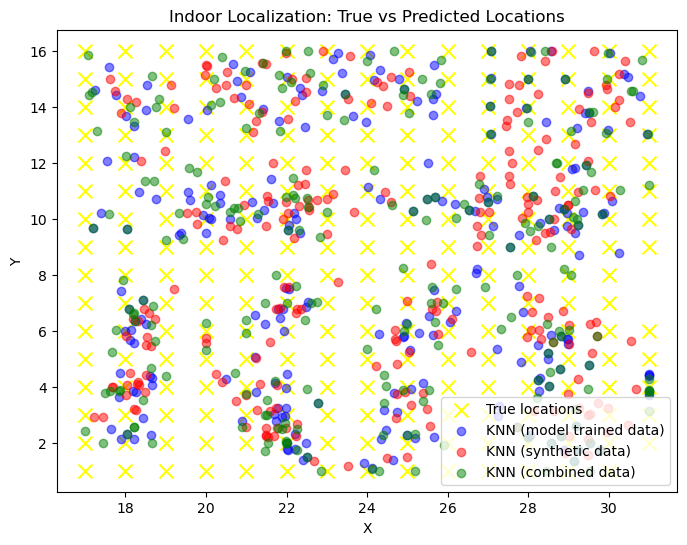

In [844]:

# Optional: Visualize some results
plt.figure(figsize=(8,6))
plt.scatter(X_knn[:,0], X_knn[:,1], c='yellow', marker='x',s=100, label="True locations")
plt.scatter(pred_locations_model_trained[:,0], pred_locations_model_trained[:,1], c='b', alpha=0.5, label="KNN (model trained data)")
plt.scatter(pred_locations_synthetic[:,0], pred_locations_synthetic[:,1], c='r', alpha=0.5, label="KNN (synthetic data)")
plt.scatter(pred_locations_combined[:,0], pred_locations_combined[:,1], c='g', alpha=0.5, label="KNN (combined data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Indoor Localization: True vs Predicted Locations")
plt.legend()
plt.show()

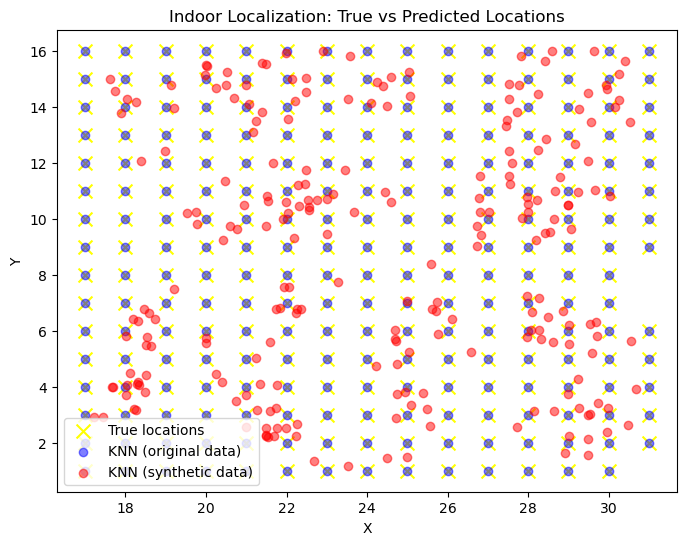

In [823]:

# Optional: Visualize some results
plt.figure(figsize=(8,6))
plt.scatter(X_knn[:,0], X_knn[:,1], c='yellow', marker='x',s=100, label="True locations")
plt.scatter(pred_locations_original[:,0], pred_locations_original[:,1], c='b', alpha=0.5, label="KNN (original data)")
plt.scatter(pred_locations_synthetic[:,0], pred_locations_synthetic[:,1], c='r', alpha=0.5, label="KNN (synthetic data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Indoor Localization: True vs Predicted Locations")
plt.legend()
plt.show()

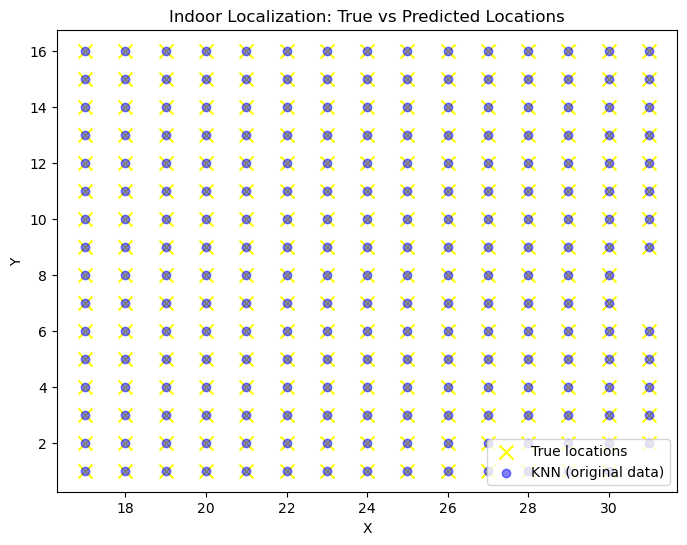

In [824]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plots for the points
plt.scatter(X_knn[:, 0], X_knn[:, 1], c='yellow', marker='x', s=100, label="True locations")
plt.scatter(pred_locations_original[:, 0], pred_locations_original[:, 1], c='b', alpha=0.5, label="KNN (original data)")

# Draw lines connecting the true points with original predictions
for i in range(len(X_knn)):
    plt.plot([X_knn[i, 0], pred_locations_original[i, 0]], 
             [X_knn[i, 1], pred_locations_original[i, 1]], 
             c='blue', linestyle='--', linewidth=1)  # Lines between true and original

# Labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Indoor Localization: True vs Predicted Locations")
plt.legend()

# Show the plot
plt.show()

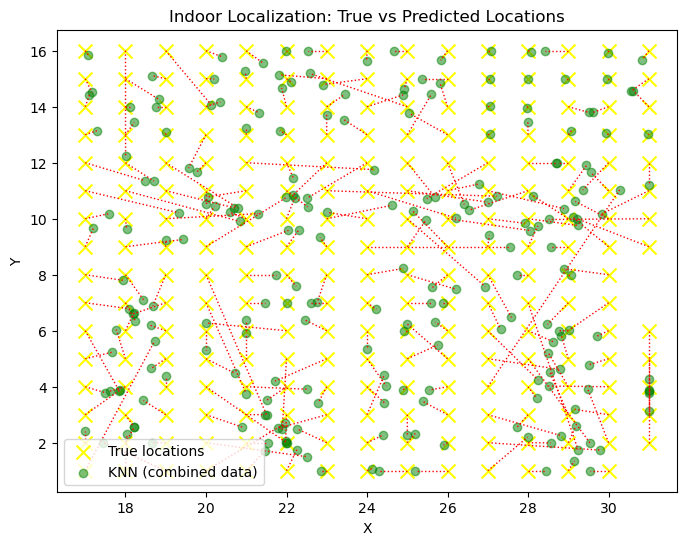

In [855]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plots for the points
plt.scatter(X_knn[:, 0], X_knn[:, 1], c='yellow', marker='x', s=100, label="True locations")
plt.scatter(pred_locations_combined[:,0], pred_locations_combined[:,1], c='g', alpha=0.5, label="KNN (combined data)")

# Draw lines connecting the true points with synthetic predictions
for i in range(len(X_knn)):
    plt.plot([X_knn[i, 0], pred_locations_combined[i, 0]], 
             [X_knn[i, 1], pred_locations_combined[i, 1]], 
             c='red', linestyle=':', linewidth=1)  # Lines between true and synthetic

# Labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Indoor Localization: True vs Predicted Locations")
plt.legend()

# Show the plot
plt.show()

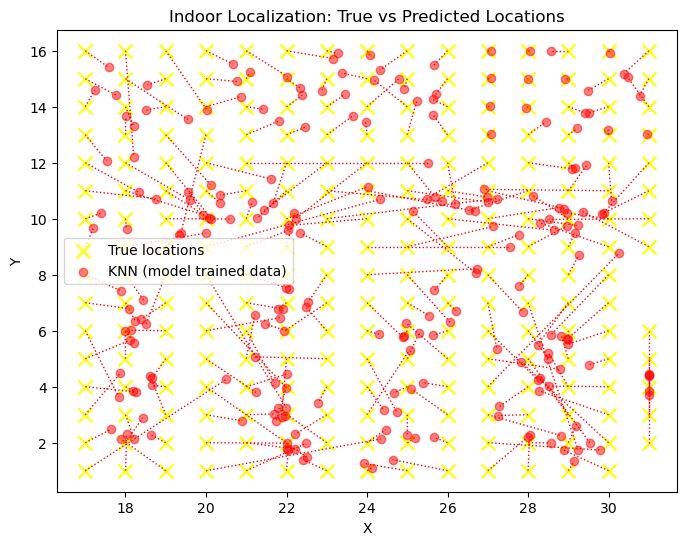

In [826]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plots for the points
plt.scatter(X_knn[:, 0], X_knn[:, 1], c='yellow', marker='x', s=100, label="True locations")
plt.scatter(pred_locations_model_trained[:, 0], pred_locations_model_trained[:, 1], c='r', alpha=0.5, label="KNN (model trained data)")


# Draw lines connecting the true points with synthetic predictions
for i in range(len(X_knn)):
    plt.plot([X_knn[i, 0], pred_locations_model_trained[i, 0]], 
             [X_knn[i, 1], pred_locations_model_trained[i, 1]], 
             c='red', linestyle=':', linewidth=1)  # Lines between true and synthetic

# Labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Indoor Localization: True vs Predicted Locations")
plt.legend()

# Show the plot
plt.show()